## Hypothesis validation notebook (synthetic_shapes_2class)

This notebook is designed to **validate / refute** the refined hypothesis:

**Hypothesis (operational):** In representation space $z=\\phi_\\ell(x)$, clean samples exhibit **class-conditional local regularity**. Adversarial samples are enriched among points exhibiting **decision–geometry inconsistency**, e.g., neighborhoods that are class-mixed/boundary-adjacent or whose class-conditional topology features are atypical for the predicted class relative to alternatives.

We keep the *attack/OOD generation unchanged* and instead vary detector components that align with the hypothesis:
- **Neighborhood semantics for topology**: global vs predicted-class restricted
- **Local metric conditioning** before PH: none vs whitening
- **Scoring rule**: typicality vs **contrastive predicted-class gap**

At minimum, we plot:
- ROC curves
- Score distributions

And we add hypothesis-driven diagnostics:
- **Neighborhood class purity** (global kNN): clean vs adversarial
- **Contrastive distance geometry**: $d_{\\hat y} - d_{\\text{other}}$ for clean vs adversarial
- **Score vs density proxy** (kNN radius): check nuisance dependence
- A few **persistence diagrams** for qualitative sanity checks


In [1]:
import pathlib
import sys
import time
from dataclasses import replace

import numpy as np
import matplotlib.pyplot as plt

# Make repo importable when running notebook from example_notebook/
repo_root = pathlib.Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.api import (
    get_dataset,
    get_model,
    train,
    generate_adversarial,
    compute_scores,
    concat_scores,
    fit_detector,
)
from src.evaluation import evaluate_detector
from src.models import get_model_predictions, extract_features_batch
from src.utils import ExperimentConfig, DataConfig, ModelConfig, AttackConfig, GraphConfig, DetectorConfig
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


### Experiment setup (fast / local-friendly)

Notes:
- `max_points_for_scoring` controls how many val/test points we compute PH features for.
- PH computation dominates runtime.
- This notebook assumes you have a PH backend installed (recommended: `ripser`).


In [2]:
SEED = 42
MAX_POINTS_FOR_SCORING = 200

cfg_base = ExperimentConfig(
    seed=SEED,
    device='cpu',
    data=DataConfig(n_samples=800, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2),
    model=ModelConfig(epochs=20, batch_size=64, learning_rate=1e-3, weight_decay=1e-4),
    attack=AttackConfig(attack_type='fgsm', epsilon=0.05),
    graph=GraphConfig(
        space='feature',
        feature_layer='penultimate',
        use_topology=True,
        topo_k=30,
        topo_preprocess='pca',
        topo_pca_dim=10,
        topo_maxdim=1,
        # New hypothesis-aligned knobs (defaults shown explicitly)
        topo_neighbor_mode='global',
        topo_metric_normalization='none',
        topo_whiten_ridge=1e-3,
        topo_k_list=None,
    ),
    detector=DetectorConfig(
        detector_type='topology_score',
        topo_percentile=95.0,
        topo_cov_shrinkage=1e-3,
        topo_class_conditional=False,
        topo_class_scoring_mode='min_over_classes',
        topo_min_clean_per_class=5,
    ),
)
cfg_base


ExperimentConfig(data=DataConfig(n_samples=800, noise=0.1, random_state=42, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, root='./data', download=False), model=ModelConfig(input_dim=2, hidden_dims=[64, 32], output_dim=2, activation='relu', learning_rate=0.001, epochs=20, batch_size=64, weight_decay=0.0001, random_state=42), attack=AttackConfig(attack_type='fgsm', epsilon=0.05, num_steps=10, step_size=0.01, random_start=True), ood=OODConfig(enabled=False, method='feature_shuffle', severity=1.0, seed=None, batch_size=128, patch_size=4, blur_kernel_size=5, blur_sigma=1.0, saltpepper_p=0.05), graph=GraphConfig(k=10, sigma=None, space='feature', feature_layer='penultimate', normalized_laplacian=True, use_diffusion=False, diffusion_components=10, use_tangent=True, tangent_k=20, tangent_dim=None, tangent_var_threshold=0.9, tangent_dim_min=2, tangent_dim_max=None, use_topology=True, topo_k=30, topo_maxdim=1, topo_metric='euclidean', topo_thresh=None, topo_min_persistence=1e-06, topo_preproce

### Train model once + generate adversarial examples

We keep the classifier fixed and vary only the detector components.

In [3]:
bundle = get_dataset('synthetic_shapes_2class', cfg_base)
model = get_model('CNN', cfg_base, num_classes=int(bundle.meta.get('num_classes', 2)), in_channels=int(bundle.X_train.shape[1]))
trained = train(model, bundle, cfg_base, device=cfg_base.device, verbose=True, return_history=False)

# Generate adversarial examples (FGSM)
clip = bundle.meta.get('clip', (0.0, 1.0))
X_adv_val = generate_adversarial(trained, bundle.X_val, bundle.y_val, cfg_base, clip=clip)
X_adv_test = generate_adversarial(trained, bundle.X_test, bundle.y_test, cfg_base, clip=clip)

print('Shapes:', bundle.X_train.shape, bundle.X_val.shape, bundle.X_test.shape)
print('Adv shapes:', X_adv_val.shape, X_adv_test.shape)


Epoch [10/20] Train Loss: 0.0340, Train Acc: 100.00%, Val Loss: 0.0443, Val Acc: 100.00%
Epoch [20/20] Train Loss: 0.0008, Train Acc: 100.00%, Val Loss: 0.0011, Val Acc: 100.00%
Shapes: (480, 3, 32, 32) (160, 3, 32, 32) (160, 3, 32, 32)
Adv shapes: (160, 3, 32, 32) (160, 3, 32, 32)


### Subsample points for PH scoring (runtime control)

We subsample clean/adv from val/test to cap PH cost. We keep the full training set as the kNN reference.

In [4]:
rng = np.random.default_rng(SEED)

def _subsample(X, y, n_max: int):
    X = np.asarray(X)
    y = np.asarray(y, dtype=int)
    if len(X) <= n_max:
        return X, y
    idx = rng.choice(np.arange(len(X)), size=int(n_max), replace=False)
    return X[idx], y[idx]

X_val_clean_used, y_val_clean_used = _subsample(bundle.X_val, bundle.y_val, MAX_POINTS_FOR_SCORING)
X_val_adv_used, y_val_adv_used = _subsample(X_adv_val, bundle.y_val, MAX_POINTS_FOR_SCORING)
X_test_clean_used, y_test_clean_used = _subsample(bundle.X_test, bundle.y_test, MAX_POINTS_FOR_SCORING)
X_test_adv_used, y_test_adv_used = _subsample(X_adv_test, bundle.y_test, MAX_POINTS_FOR_SCORING)

print('Val used:', X_val_clean_used.shape, X_val_adv_used.shape)
print('Test used:', X_test_clean_used.shape, X_test_adv_used.shape)


Val used: (160, 3, 32, 32) (160, 3, 32, 32)
Test used: (160, 3, 32, 32) (160, 3, 32, 32)


### Variant runner

For each variant:
- compute topology features on VAL and fit detector threshold on clean quantile
- score TEST (clean vs adv)
- compute ROC/PR metrics + thresholded metrics


In [5]:
def _needs_y_pred(det_cfg: DetectorConfig) -> bool:
    if not bool(getattr(det_cfg, 'topo_class_conditional', False)):
        return False
    m = str(getattr(det_cfg, 'topo_class_scoring_mode', 'min_over_classes')).strip().lower()
    return m in {'predicted_class', 'pred', 'contrastive_pred_gap', 'contrastive', 'pred_gap'}


def run_variant(*, name: str, cfg: ExperimentConfig):
    t0 = time.perf_counter()

    # Compute score dicts
    scores_val_clean = compute_scores(X_val_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_val_adv = compute_scores(X_val_adv_used, trained, bundle=bundle, cfg=cfg)
    scores_test_clean = compute_scores(X_test_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_test_adv = compute_scores(X_test_adv_used, trained, bundle=bundle, cfg=cfg)

    # Build concatenated VAL for fitting
    scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[any_key]), dtype=int),
        np.ones(len(scores_val_adv[any_key]), dtype=int)
    ])
    y_val_all = np.concatenate([np.asarray(y_val_clean_used, dtype=int), np.asarray(y_val_adv_used, dtype=int)])

    # Provide y_pred if scoring mode needs it
    y_pred_val_all = None
    if _needs_y_pred(cfg.detector):
        y_pred_val_clean = get_model_predictions(trained, np.asarray(X_val_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_val_adv = get_model_predictions(trained, np.asarray(X_val_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_val_all = np.concatenate([np.asarray(y_pred_val_clean, dtype=int), np.asarray(y_pred_val_adv, dtype=int)])

    detector = fit_detector(scores_val_all, labels_val, cfg, y_true=y_val_all, y_pred=y_pred_val_all)

    # Score TEST
    scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
    any_key_t = next(iter(scores_test_all.keys()))
    labels_test = np.concatenate([
        np.zeros(len(scores_test_clean[any_key_t]), dtype=int),
        np.ones(len(scores_test_adv[any_key_t]), dtype=int)
    ])

    y_pred_test_all = None
    if _needs_y_pred(cfg.detector):
        y_pred_test_clean = get_model_predictions(trained, np.asarray(X_test_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_test_adv = get_model_predictions(trained, np.asarray(X_test_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_test_all = np.concatenate([np.asarray(y_pred_test_clean, dtype=int), np.asarray(y_pred_test_adv, dtype=int)])

    # detector.score signature differs across detector types; call via the common helper pattern
    try:
        raw_scores_test = detector.score(scores_test_all, y_pred=y_pred_test_all)
    except TypeError:
        raw_scores_test = detector.score(scores_test_all)

    thr = float(getattr(detector, 'threshold', np.nan))
    metrics = evaluate_detector(np.asarray(labels_test, dtype=int), np.asarray(raw_scores_test, dtype=float), threshold=thr)
    wall = time.perf_counter() - t0

    return {
        'name': str(name),
        'cfg': cfg,
        'detector': detector,
        'scores_test_all': scores_test_all,
        'labels_test': labels_test,
        'raw_scores_test': np.asarray(raw_scores_test, dtype=float),
        'threshold': thr,
        'metrics': metrics,
        'wall_s': float(wall),
        'y_pred_test_all': y_pred_test_all,
        'scores_test_clean': scores_test_clean,
        'scores_test_adv': scores_test_adv,
    }


### Define variants (hypothesis-aligned ablations)

We keep the same model/attack, and vary only:
- topology neighborhood semantics
- local metric conditioning
- scoring rule


In [6]:
variants = []

# V0: baseline (legacy): pooled scoring, global neighborhood, no metric conditioning
cfg_v0 = cfg_base
variants.append(('V0_pooled_global', cfg_v0))

# V1: class-conditional scoring (typicality), still global neighborhood
cfg_v1 = replace(cfg_base, detector=replace(cfg_base.detector, topo_class_conditional=True, topo_class_scoring_mode='min_over_classes'))
variants.append(('V1_classcond_global', cfg_v1))

# V2: class-conditional + predicted-class-restricted neighborhoods (decision-aware topology)
cfg_v2 = replace(
    cfg_v1,
    graph=replace(cfg_v1.graph, topo_neighbor_mode='class_pred'),
)
variants.append(('V2_classcond_classPredNbr', cfg_v2))

# V3: add local metric conditioning (whiten)
cfg_v3 = replace(
    cfg_v2,
    graph=replace(cfg_v2.graph, topo_metric_normalization='whiten', topo_whiten_ridge=1e-3),
)
variants.append(('V3_classPredNbr_whiten', cfg_v3))

# V4: decision–geometry inconsistency scoring (contrastive predicted gap)
cfg_v4 = replace(
    cfg_v3,
    detector=replace(cfg_v3.detector, topo_class_scoring_mode='contrastive_pred_gap'),
)
variants.append(('V4_contrastive_gap', cfg_v4))

len(variants), [n for n,_ in variants]


(5,
 ['V0_pooled_global',
  'V1_classcond_global',
  'V2_classcond_classPredNbr',
  'V3_classPredNbr_whiten',
  'V4_contrastive_gap'])

### Run variants

In [7]:
results = []
for name, cfg in variants:
    print('Running', name)
    res = run_variant(name=name, cfg=cfg)
    results.append(res)
    m = res['metrics']
    print('  roc_auc=', m.get('roc_auc'), 'pr_auc=', m.get('pr_auc'), 'fpr@95=', m.get('fpr_at_tpr95'), 'wall_s=', res['wall_s'])

results[0].keys()


Running V0_pooled_global
  roc_auc= 0.8984375 pr_auc= 0.9137181377818641 fpr@95= 0.6 wall_s= 14.445697458
Running V1_classcond_global
  roc_auc= 0.8969140625 pr_auc= 0.9111602469125119 fpr@95= 0.4625 wall_s= 13.799382167000001
Running V2_classcond_classPredNbr
  roc_auc= 0.8969140625 pr_auc= 0.9111602469125119 fpr@95= 0.4625 wall_s= 13.615193542
Running V3_classPredNbr_whiten
  roc_auc= 0.988046875 pr_auc= 0.9896316717276925 fpr@95= 0.08125 wall_s= 14.83460925
Running V4_contrastive_gap
  roc_auc= 0.3884375 pr_auc= 0.5260618484779458 fpr@95= 1.0 wall_s= 14.89181529199999


dict_keys(['name', 'cfg', 'detector', 'scores_test_all', 'labels_test', 'raw_scores_test', 'threshold', 'metrics', 'wall_s', 'y_pred_test_all', 'scores_test_clean', 'scores_test_adv'])

### Summary table

In [8]:
def _row(r):
    m = r['metrics']
    return {
        'name': r['name'],
        'roc_auc': float(m.get('roc_auc', np.nan)),
        'pr_auc': float(m.get('pr_auc', np.nan)),
        'fpr_at_tpr95': float(m.get('fpr_at_tpr95', np.nan)),
        'accuracy': float(m.get('accuracy', np.nan)),
        'f1': float(m.get('f1', np.nan)),
        'threshold': float(r['threshold']),
        'wall_s': float(r['wall_s']),
        'topo_neighbor_mode': str(getattr(r['cfg'].graph, 'topo_neighbor_mode', 'global')),
        'topo_metric_norm': str(getattr(r['cfg'].graph, 'topo_metric_normalization', 'none')),
        'score_mode': str(getattr(r['cfg'].detector, 'topo_class_scoring_mode', 'pooled')),
    }

rows = [_row(r) for r in results]
rows


[{'name': 'V0_pooled_global',
  'roc_auc': 0.8984375,
  'pr_auc': 0.9137181377818641,
  'fpr_at_tpr95': 0.6,
  'accuracy': 0.8375,
  'f1': 0.8194444444444445,
  'threshold': 3.0862008674320194,
  'wall_s': 14.445697458,
  'topo_neighbor_mode': 'global',
  'topo_metric_norm': 'none',
  'score_mode': 'min_over_classes'},
 {'name': 'V1_classcond_global',
  'roc_auc': 0.8969140625,
  'pr_auc': 0.9111602469125119,
  'fpr_at_tpr95': 0.4625,
  'accuracy': 0.840625,
  'f1': 0.8210526315789474,
  'threshold': 2.962309998030004,
  'wall_s': 13.799382167000001,
  'topo_neighbor_mode': 'global',
  'topo_metric_norm': 'none',
  'score_mode': 'min_over_classes'},
 {'name': 'V2_classcond_classPredNbr',
  'roc_auc': 0.8969140625,
  'pr_auc': 0.9111602469125119,
  'fpr_at_tpr95': 0.4625,
  'accuracy': 0.840625,
  'f1': 0.8210526315789474,
  'threshold': 2.962309998030004,
  'wall_s': 13.615193542,
  'topo_neighbor_mode': 'class_pred',
  'topo_metric_norm': 'none',
  'score_mode': 'min_over_classes'},
 

### ROC curves (all variants)

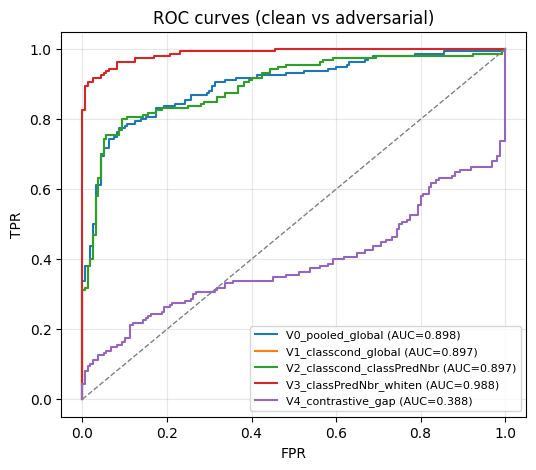

In [9]:
plt.figure(figsize=(6, 5))
for r in results:
    fpr = np.asarray(r['metrics']['fpr'])
    tpr = np.asarray(r['metrics']['tpr'])
    auc = float(r['metrics']['roc_auc'])
    plt.plot(fpr, tpr, label=f"{r['name']} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves (clean vs adversarial)')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


### Score distributions (clean vs adversarial)

We plot the detector score distributions on TEST, using each variant’s calibrated threshold.

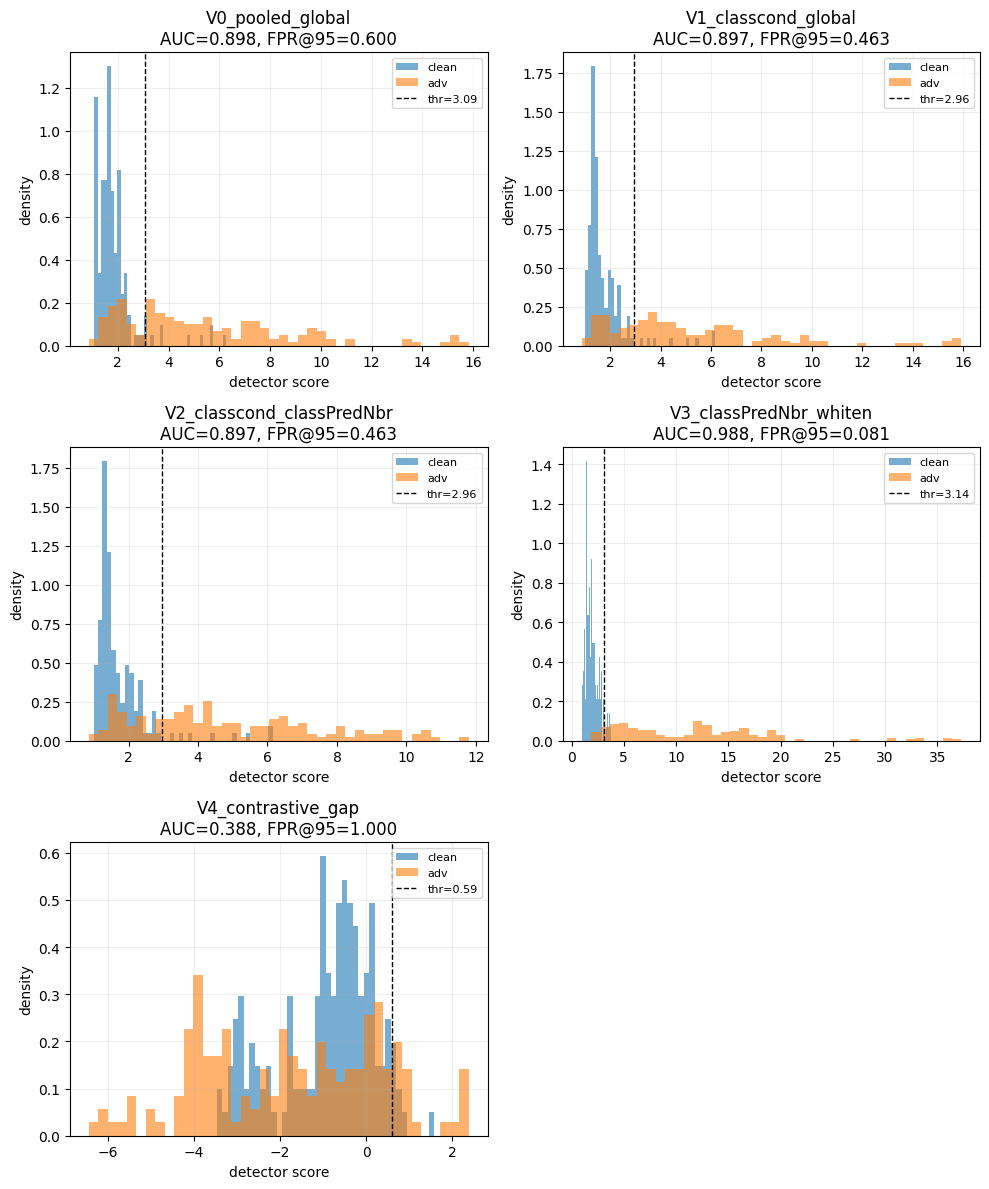

In [10]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4*nrows), squeeze=False)

for ax, r in zip(axes.ravel(), results):
    y = np.asarray(r['labels_test'], dtype=int)
    s = np.asarray(r['raw_scores_test'], dtype=float)
    thr = float(r['threshold'])

    s_clean = s[y == 0]
    s_adv = s[y == 1]

    ax.hist(s_clean, bins=40, alpha=0.6, label='clean', density=True)
    ax.hist(s_adv, bins=40, alpha=0.6, label='adv', density=True)
    ax.axvline(thr, color='k', linestyle='--', linewidth=1, label=f"thr={thr:.2f}")
    ax.set_title(f"{r['name']}\nAUC={float(r['metrics']['roc_auc']):.3f}, FPR@95={float(r['metrics']['fpr_at_tpr95']):.3f}")
    ax.set_xlabel('detector score')
    ax.set_ylabel('density')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)

for ax in axes.ravel()[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Hypothesis diagnostics

### 1) Global neighborhood class purity (clean vs adversarial)

If adversarial examples tend to be **boundary-adjacent / class-mixed**, then under a *global* kNN search in representation space we should see lower neighbor purity for adversarial points.


Purity (pred-class) mean±std:
  clean: 1.0 ± 0.0
  adv  : 0.9912500000000002 ± 0.0525049600831515


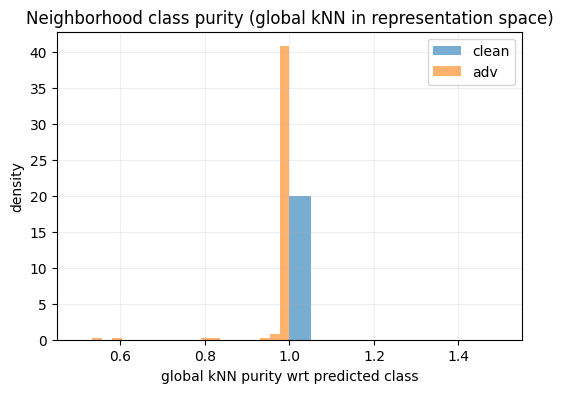

In [11]:
# Compute penultimate embeddings for training and test points
Z_train = extract_features_batch(trained, bundle.X_train, layer=str(cfg_base.graph.feature_layer), device=str(cfg_base.device))
y_train = np.asarray(bundle.y_train, dtype=int)

X_test_all = np.concatenate([X_test_clean_used, X_test_adv_used], axis=0)
y_type = np.concatenate([
    np.zeros(len(X_test_clean_used), dtype=int),
    np.ones(len(X_test_adv_used), dtype=int)
])
Z_test_all = extract_features_batch(trained, X_test_all, layer=str(cfg_base.graph.feature_layer), device=str(cfg_base.device))
y_pred_test_all = get_model_predictions(trained, X_test_all, device=str(cfg_base.device), return_probs=False).astype(int)

K = int(cfg_base.graph.topo_k)
nbrs = NearestNeighbors(n_neighbors=min(K, len(Z_train)), metric='euclidean').fit(Z_train)
dists, idx = nbrs.kneighbors(Z_test_all)
neigh_labels = y_train[idx]  # (N, K)

# Purity wrt predicted class: fraction of neighbors that match y_pred
purity_pred = (neigh_labels == y_pred_test_all.reshape(-1, 1)).mean(axis=1)

pur_clean = purity_pred[y_type == 0]
pur_adv = purity_pred[y_type == 1]

print('Purity (pred-class) mean±std:')
print('  clean:', float(pur_clean.mean()), '±', float(pur_clean.std()))
print('  adv  :', float(pur_adv.mean()), '±', float(pur_adv.std()))

plt.figure(figsize=(6, 4))
plt.hist(pur_clean, bins=20, alpha=0.6, density=True, label='clean')
plt.hist(pur_adv, bins=20, alpha=0.6, density=True, label='adv')
plt.xlabel('global kNN purity wrt predicted class')
plt.ylabel('density')
plt.title('Neighborhood class purity (global kNN in representation space)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


### 2) Contrastive distance geometry (decision–geometry inconsistency)

For a class-conditional detector we can visualize distances to each class in topology-feature space.
In binary classification this simplifies to comparing distance to predicted vs the other class.


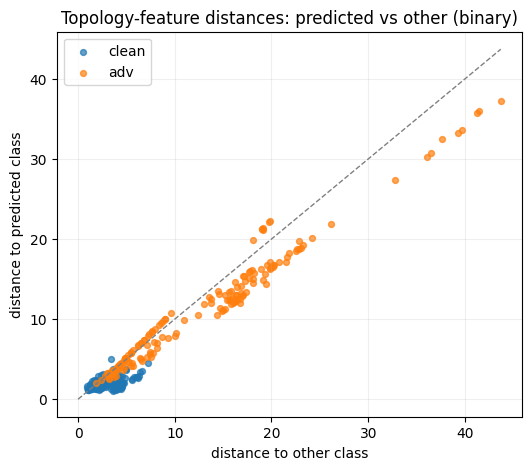

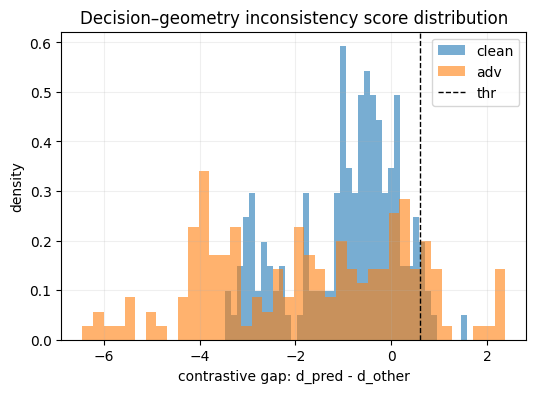

In [12]:
# Use the most hypothesis-aligned variant (contrastive gap) for this plot.
r_gap = next(r for r in results if r['name'] == 'V4_contrastive_gap')
det = r_gap['detector']
scores = r_gap['scores_test_all']
y = np.asarray(r_gap['labels_test'], dtype=int)
y_pred = np.asarray(r_gap['y_pred_test_all'], dtype=int)

# Access internal feature matrix and per-class distances (binary case).
X_feat = det._feature_matrix(scores)
classes = det.classes_.tolist()
assert len(classes) == 2, f"Expected binary classes; got {classes}"
c0, c1 = int(classes[0]), int(classes[1])
d0 = det._score_against_class(X_feat, c=c0)
d1 = det._score_against_class(X_feat, c=c1)
d_pred = np.where(y_pred == c0, d0, d1)
d_other = np.where(y_pred == c0, d1, d0)
gap = d_pred - d_other

plt.figure(figsize=(6, 5))
plt.scatter(d_other[y == 0], d_pred[y == 0], s=18, alpha=0.7, label='clean')
plt.scatter(d_other[y == 1], d_pred[y == 1], s=18, alpha=0.7, label='adv')
mx = float(max(d_other.max(), d_pred.max()))
plt.plot([0, mx], [0, mx], '--', color='gray', linewidth=1)
plt.xlabel('distance to other class')
plt.ylabel('distance to predicted class')
plt.title('Topology-feature distances: predicted vs other (binary)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(gap[y == 0], bins=40, alpha=0.6, density=True, label='clean')
plt.hist(gap[y == 1], bins=40, alpha=0.6, density=True, label='adv')
plt.axvline(float(r_gap['threshold']), color='k', linestyle='--', linewidth=1, label='thr')
plt.xlabel('contrastive gap: d_pred - d_other')
plt.ylabel('density')
plt.title('Decision–geometry inconsistency score distribution')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


### 3) Score vs density proxy (kNN radius)

If the detector is mostly capturing density/scale artifacts, the score will be strongly correlated with kNN radius.
Metric normalization (e.g., whitening) should reduce this nuisance coupling.

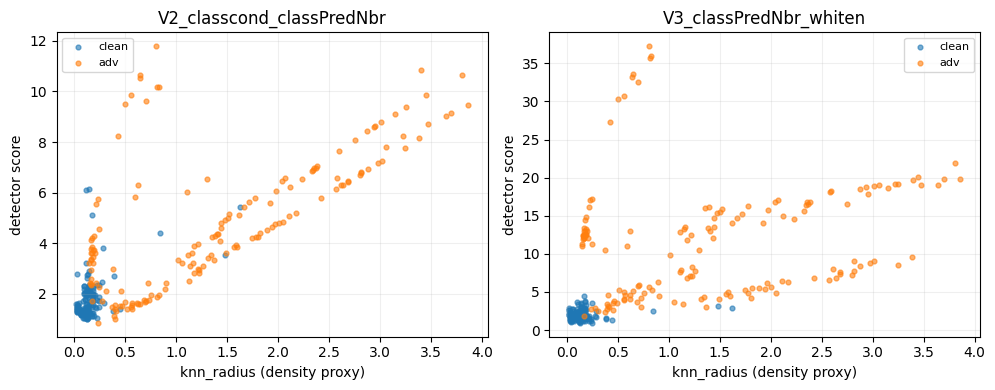

In [13]:
def _get_knn_radius(scores_dict):
    if 'knn_radius' not in scores_dict:
        return None
    return np.asarray(scores_dict['knn_radius'], dtype=float)

plt.figure(figsize=(10, 4))
for j, key in enumerate(['V2_classcond_classPredNbr', 'V3_classPredNbr_whiten']):
    r = next(rr for rr in results if rr['name'] == key)
    rad = _get_knn_radius(r['scores_test_all'])
    if rad is None:
        continue
    s = np.asarray(r['raw_scores_test'], dtype=float)
    y = np.asarray(r['labels_test'], dtype=int)
    ax = plt.subplot(1, 2, j+1)
    ax.scatter(rad[y==0], s[y==0], s=12, alpha=0.6, label='clean')
    ax.scatter(rad[y==1], s[y==1], s=12, alpha=0.6, label='adv')
    ax.set_xlabel('knn_radius (density proxy)')
    ax.set_ylabel('detector score')
    ax.set_title(key)
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


### 4) Qualitative embedding visualization (PCA of representation)

This is not a topology plot, but helps interpret whether adversarial points are boundary-adjacent in representation space.

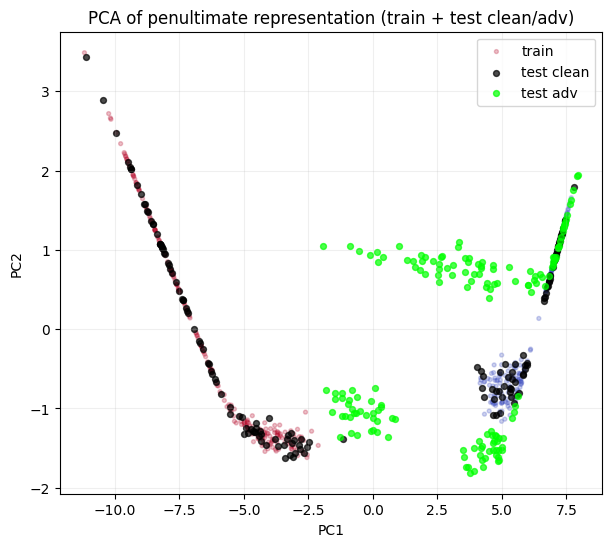

In [14]:
pca2 = PCA(n_components=2, random_state=SEED)
Z2_train = pca2.fit_transform(Z_train)
Z2_test = pca2.transform(Z_test_all)

plt.figure(figsize=(7, 6))
plt.scatter(Z2_train[:,0], Z2_train[:,1], c=y_train, s=8, alpha=0.25, cmap='coolwarm', label='train')
plt.scatter(Z2_test[y_type==0,0], Z2_test[y_type==0,1], c='k', s=18, alpha=0.7, label='test clean')
plt.scatter(Z2_test[y_type==1,0], Z2_test[y_type==1,1], c='lime', s=18, alpha=0.7, label='test adv')
plt.title('PCA of penultimate representation (train + test clean/adv)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


### 5) Persistence diagrams for a few selected examples

We compare one clean and one adversarial example under the *same* topology configuration.
This is a qualitative sanity check (diagrams can be noisy at small k).


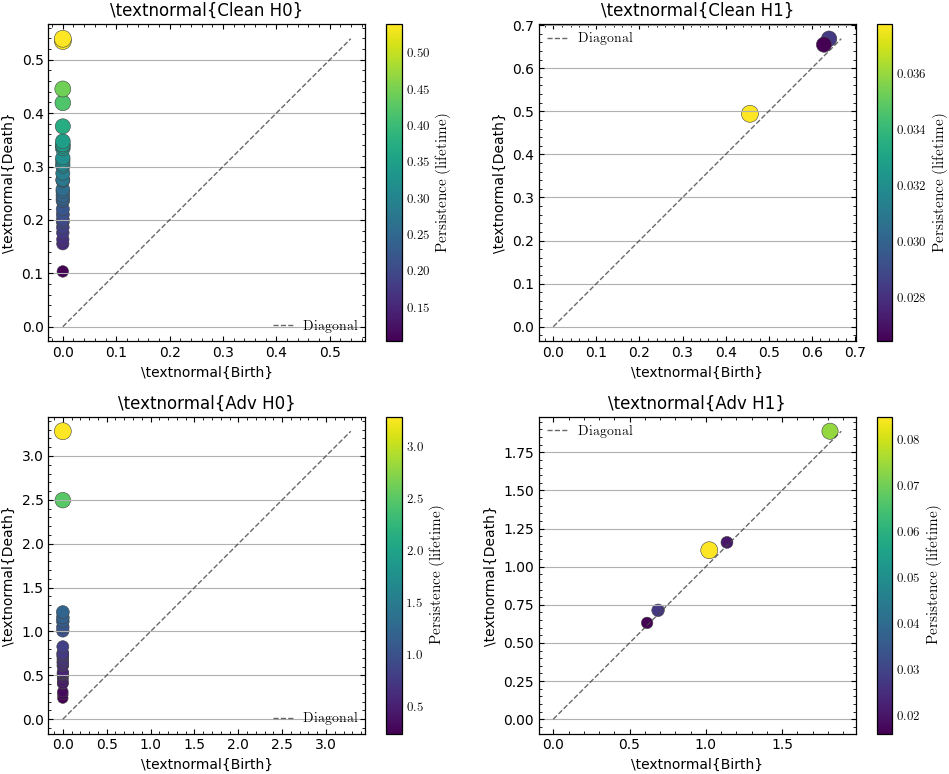

Clean topo summaries: {'topo_h0_count': 30.0, 'topo_h0_total_persistence': 8.586764745414257, 'topo_h0_max_persistence': 0.5393362045288086, 'topo_h0_l2_persistence': 1.6644921036713436, 'topo_h0_entropy': 3.3395142110511937, 'topo_h1_count': 3.0, 'topo_h1_total_persistence': 0.0924997627735138, 'topo_h1_max_persistence': 0.03774407505989075, 'topo_h1_l2_persistence': 0.054087771837606304, 'topo_h1_entropy': 1.0860996482471654}
Adv topo summaries: {'topo_h0_count': 30.0, 'topo_h0_total_persistence': 23.984360963106155, 'topo_h0_max_persistence': 3.282151699066162, 'topo_h0_l2_persistence': 5.5414456678064505, 'topo_h0_entropy': 3.188045702637951, 'topo_h1_count': 5.0, 'topo_h1_total_persistence': 0.22190040349960327, 'topo_h1_max_persistence': 0.08492541313171387, 'topo_h1_l2_persistence': 0.11845684838423524, 'topo_h1_entropy': 1.398737812418457}


In [15]:
from src.graph_scoring import compute_graph_scores_with_diagrams
from src.visualization import plot_persistence_diagram
import torch

# Choose a clean and an adv point
x_clean = X_test_clean_used[0]
x_adv = X_test_adv_used[0]

# Reconstruct f_train and Z_train consistent with cfg_base
logits_train = trained(torch.as_tensor(bundle.X_train, dtype=torch.float32)).detach().cpu().numpy()
probs_train = np.exp(logits_train - logits_train.max(axis=1, keepdims=True))
probs_train = probs_train / probs_train.sum(axis=1, keepdims=True)
f_train = probs_train[:, 1]  # binary

feats_clean, diagrams_clean, cloud_clean = compute_graph_scores_with_diagrams(
    np.asarray(x_clean, dtype=float),
    trained,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train),
    graph_params=cfg_v3.graph,  # whitened (hypothesis-aligned)
    device=str(cfg_base.device),
)
feats_adv, diagrams_adv, cloud_adv = compute_graph_scores_with_diagrams(
    np.asarray(x_adv, dtype=float),
    trained,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train),
    graph_params=cfg_v3.graph,
    device=str(cfg_base.device),
)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plot_persistence_diagram(diagrams_clean[0], dimension=0, title='Clean H0', ax=axes[0,0])
plot_persistence_diagram(diagrams_clean[1], dimension=1, title='Clean H1', ax=axes[0,1])
plot_persistence_diagram(diagrams_adv[0], dimension=0, title='Adv H0', ax=axes[1,0])
plot_persistence_diagram(diagrams_adv[1], dimension=1, title='Adv H1', ax=axes[1,1])
plt.tight_layout()
plt.show()

print('Clean topo summaries:', feats_clean)
print('Adv topo summaries:', feats_adv)
